<a href="https://csdms.colorado.edu"><img style="float: center; width: 75%" src="../../media/ESPIn.png"></a>

# Introduction to Landlab: Grids, Landlab as a solver for advection-diffusion problems, some demos

This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space / upwind numerical scheme. 

The numerical examples we have covered so far are all pretty simple. If this was all you needed to do, you wouldn't need Landlab. 

But what if you wanted...

... to use the same diffusion model in 2D instead of 1D.

... to use an irregular grid (in 1 or 2D). 

... wanted to combine the diffusion model with a more complex model. 

... have a more complex model you want to use over and over again with different boundary conditions.

These are the sorts of problems that Landlab was designed to solve. 

In Part 1 we will use the RasterModelGrid, fields, and a numerical utility for calculating flux divergence. 

Landlab is often times associated with terrestrial processes. But the library provides a very rich ecosystem to tackle all kind of geophysical problems (other than the 'land'). To showcase this, we will solve the same advection and diffusion equations we solved before, but this time in 2 dimensions and using the landlab toolkit to build a model.  


## Landlab's Model Grids

The Landlab model grids are data structures that represent the model domain (the variable `x` in our prior example). Here we will use `RasterModelGrid` which creates a grid with regularly spaced square grid elements. The RasterModelGrid knows how the elements are connected and how far apart they are.

Lets start by creating a RasterModelGrid class. First we need to import it. 

### What are landlab grids (the gridding engine):
 - Two-dimensional simulation grid of a user-specified size and shape
 - Grids are represented as Python objects
     - data (geomtery, topology)
     - methods (functions to perform operations using the data)
 - Landlab mainly supports 2D grids 
 
### What you need to know about grids: 

<img src="../../media/Grids1.png"/>

**Figure** Geometry and topology of grid elements on various Landlab grids ([Hobley et al. 2017](https://esurf.copernicus.org/articles/5/21/2017/))

- a set of primitive elements (see figure)
- the entire grid can be generated from a description of the geometry of only one of these element types – typically, a user might specify the locations of the nodes, and the grid object’s remaining elements are automatically placed according to this node framework.
- bounding elements are a set of nodes (grids are finite)
        => A grid has nodes than cells

-- Landlab provides support for regular and irregular grids. In the following examples, we will work with regular grids. 

### (a) Explore the RasterModelGrid

Before we use a RasterModelGrid to solve our example, lets explore it a bit closer. 

In [69]:
from landlab import RasterModelGrid

> RasterModelGrid refers to a `class` (OOP)

We'll start with a 3-row by 4-column raster grid, with 10-meter node spacing by creating an instance of the class RastermodelGrid

#### First, the nodes

> How many cells has this grid? 

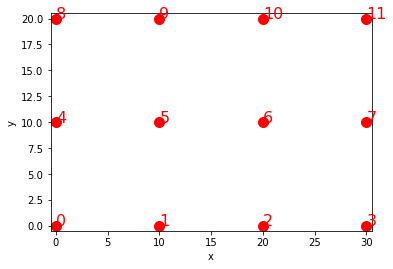

In [96]:
import numpy as np
from landlab.plot.graph import plot_graph
grid = RasterModelGrid((3, 4), 10.0)
plot_graph(grid, at="node")

You can see that the nodes are points and they are numbered with unique IDs from lower left to upper right. 

Not sure how to use he RasterModelGrid class? 
Bring up the documentation

In [71]:
?RasterModelGrid

You can see that the nodes are points and they are numbered with unique IDs from lower left to upper right. 

Create a scalar field called z, representing elevation of the land surface, at the grid nodes:

Next we'll add a data field to the grid, to represent the elevation values at grid nodes. The "dot" syntax below indicates that we are calling a function (or method) that belongs to the RasterModelGrid class, and will act on data contained in mg. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field topographic__elevation. The add_zeros method returns the newly created NumPy array.

In [72]:
z = grid.add_zeros('topographic__elevation', at='node')
z[5] = 5.0
z[6] = 3.6

Nodes 5 and 6 are the only core nodes; the rest are (so far) open boundaries.

Here are the values.

In [73]:
z

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  5. ,  3.6,  0. ,  0. ,  0. ,  0. ,
        0. ])

In [74]:
print(grid.at_node["topographic__elevation"])

[ 0.   0.   0.   0.   0.   5.   3.6  0.   0.   0.   0.   0. ]


Let's take a graphical look at the elevation grid we've created. To do so, we'll use the matplotlib graphics library (imported under the name plt). We also have to tell the Jupyter Notebook to display plots right here on the page. Finally, we will import Landlab's imshow_grid function to display our gridded values.

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
from landlab.plot.imshow import imshow_grid

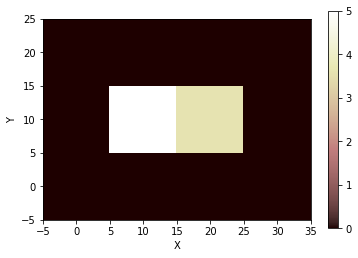

In [76]:
imshow_grid(grid, 'topographic__elevation')

There are elevation values associated with all 12 of the nodes on the grid. The ones shown in black are boundary nodes; the two in the middle are core nodes. This is our scalar field.

> Note: you can assign multiple fields to a node! You can make as many fields as you like and assign it to any element of the grid (nodes/links etc). Try to add a second field to the nodes

In [77]:
grid.add_zeros('soil_depth',at='node')

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [78]:
# Change value in soil depth grid (class)
# Show referncing to memory when chaning z

#### Second, the links

We want to find the gradient between each pair of adjacent nodes, and store that value at the associated **link** between them.

##### What are links?

For each pair of adjacent nodes in a Landlab grid, there is a corresponding **link**. Links are directed line segments whose endpoints are the coordinates of the nodes. A link can be illustrated like this:

    o---->o

Here, each o represents a node, and the arrow is the link. A "vertical" link looks like this:

    o
    ^
    |
    |
    o

The tip of the arrow is known as the **link head**; the base of the arrow is known as the **link tail**. By default, links always "point" within the upper-right half-plane.

With this definition of links in mind, we can sketch our grid like so, with the ID numbers of the nodes shown by the numbers:


    8 ----> 9 ----> 10----> 11
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    4 ----> 5 ----> 6 ----> 7
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 1 ----> 2 ----> 3


If we label each node with its elevation value, it looks like this:


    0 ----> 0 ----> 0 ----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ---->5.0---->3.6----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 0 ----> 0 ----> 0
    

Let's plot the layout of the links of our ealier created grid object:

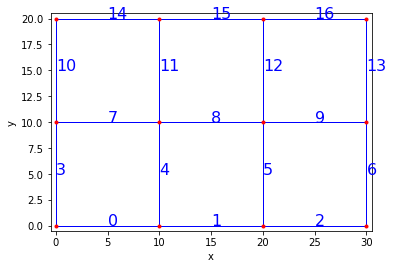

In [79]:
plot_graph(grid, at="link")

which are lines that connect the nodes and each have a unique ID number. 

We can also plot the cells which are polygons centered around the nodes. 

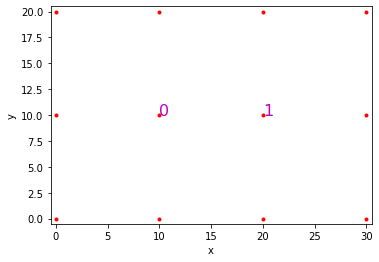

In [80]:
plot_graph(grid, at="cell")

Landlab is a "dual" graph because it also keeps track of a second set of points, lines, and polygons ("corners", "faces", and "patches"). We will not focus on them further.

An overview ([Hobley et al. 2017](https://esurf.copernicus.org/articles/5/21/2017/)): 
<img src="../../media/Grids3.png"/>

### *Exercises for section 2a*

(2a.1) Create an instance of a `RasterModelGrid` with 5 rows and 7 columns, with a spacing between nodes of 10 units. Plot the node layout, and identify the ID number of the center-most node.

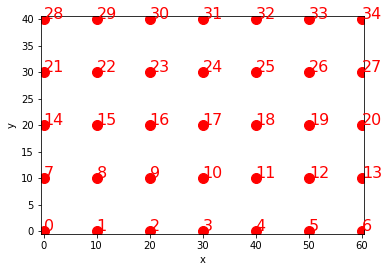

In [81]:
# (enter your solution to 2a.1 here)


(2a.2) Find the ID of the cell that contains this node.

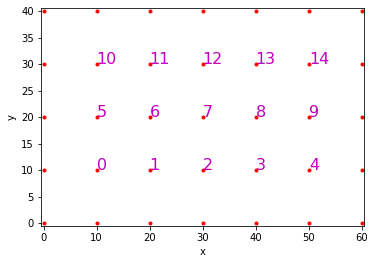

In [82]:
# (enter your solution to 2a.2 here)


(2a.3) Find the ID of the horizontal link that connects to the last node on the right in the middle column.

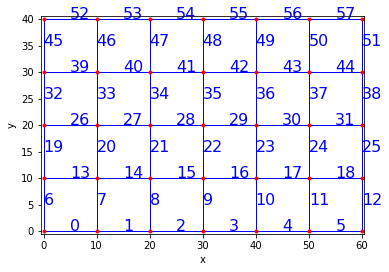

In [97]:
# (enter your solution to 2a.3 here)


rmg.links_at_node[0]

# Gradients
To calculate the flux of particles, we need to know the gradient gradient of a node field, with one gradient value for each link. Calculate the gradient for the grid defined in part  1 by using the function calc_grad_at_link:

In [84]:
dzdx = grid.calc_grad_at_link(z)
dzdx

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.36,  0.  ,  0.5 , -0.14,
       -0.36,  0.  , -0.5 , -0.36,  0.  ,  0.  ,  0.  ,  0.  ])

Here's a crude graphical representation of gradient array:


    o ---0--> o ---0--> o ---0--> o
    ^         ^         ^         ^
    0       -0.5      -0.36       0
    |         |         |         |
    o  +0.5 > o -0.14 > o -0.36 > o
    ^         ^         ^         ^
    0       +0.5      +0.36       0
    |         |         |         |
    o ---0--> o ---0--> 0 ---0--> 0

Links are listed in order by the $(x, y)$ coordinates of their midpoints. The ID numbering scheme for our links looks like this:


    o --14--> o --15--> o --16--> o
    ^         ^         ^         ^
    10       11        12        13
    |         |         |         |
    o ---7--> o ---8--> o ---9--> o
    ^         ^         ^         ^
    3         4         5         6
    |         |         |         |
    o ---0--> o ---1--> 0 ---2--> 0

Let's explore how the geometry and the values in the ID array of gradients correspond. Here are the gradients first three are the horizontal links along the bottom edge of the grid:

In [85]:
dzdx[0:3]

array([ 0.,  0.,  0.])

Next come four vertical links that connect the bottom to the middle rows of nodes. Two of these values are positive, indicating an uphill gradient in the direction of the links:

In [86]:
dzdx[3:7]

array([ 0.  ,  0.5 ,  0.36,  0.  ])

Now the middle row of horizontal links:

In [87]:
dzdx[7:10]

array([ 0.5 , -0.14, -0.36])

The next row of vertical links. The middle two of these are negative, indicating a downhill slope in the direction of the links:

In [88]:
dzdx[10:14]

array([ 0.  , -0.5 , -0.36,  0.  ])

Finally, the top row of horizontal links:

In [89]:
dzdx[14:17]

array([ 0.,  0.,  0.])

An alternative way to inspect link-based values in a raster grid is to use the horizontal_links and vertical_links grid attributes:

In [90]:
dzdx[grid.horizontal_links]

array([ 0.  ,  0.  ,  0.  ,  0.5 , -0.14, -0.36,  0.  ,  0.  ,  0.  ])

In [91]:
dzdx[grid.horizontal_links]

array([ 0.  ,  0.  ,  0.  ,  0.5 , -0.14, -0.36,  0.  ,  0.  ,  0.  ])

### *Exercises for section 2c*

(2c.1) Make a 3x3 `RasterModelGrid` called `tinygrid`, with a cell spacing of 2 m. Use the `plot_graph` function to display the nodes and their ID numbers.

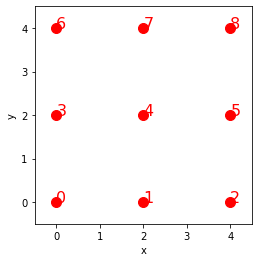

In [98]:
# (enter your solution to 2c.1 here)


(2c.2) Give your `tinygrid` a node field called `height` and set the height of the center-most node to 0.5. Use `imshow_grid` to display the height field.

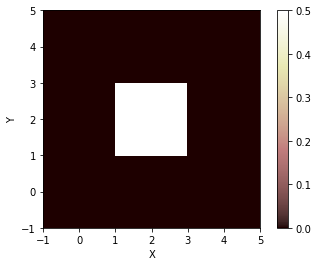

In [93]:
# (enter your solution to 2c.2 here)


(2c.3) The grid should have 12 links (extra credit: verify this with `plot_graph`). When you compute gradients, which of these links will have non-zero gradients? What will the absolute value(s) of these gradients be? Which (if any) will have positive gradients and which negative? To codify your answers, make a 12-element numpy array that contains your predicted gradient value for each link.

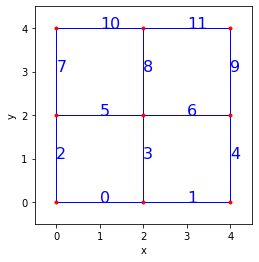

[ 0.    0.    0.    0.25  0.    0.25 -0.25  0.   -0.25  0.    0.    0.  ]


In [102]:
# (enter your solution to 2c.3 here)


(2c.4) Test your prediction by running the `calc_grad_at_link` function on your tiny grid. Print the resulting array and compare it with your predictions.

In [103]:
# (enter your solution to 2c.4 here)


[ 0.    0.    0.    0.25  0.    0.25 -0.25  0.   -0.25  0.    0.    0.  ]


(2c.5) Suppose the flux of soil per unit cell width is defined as -0.01 times the height gradient. What would the flux be at the those links that have non-zero gradients? Test your prediction by creating and printing a new array whose values are equal to -0.01 times the link-gradient values.

In [104]:
# (enter your solution to 2c.5 here)


[-0.     -0.     -0.     -0.0025 -0.     -0.0025  0.0025 -0.      0.0025
 -0.     -0.     -0.    ]


(2c.6) Consider the net soil accumulation or loss rate around the center-most node in your tiny grid (which is the only one that has a cell). The *divergence* of soil flux can be represented numerically as the sum of the total volumetric soil flux across each of the cell's four faces. What is the flux across each face? (Hint: multiply by face width) What do they add up to? Test your prediction by running the grid function `calc_flux_div_at_node` (hint: pass your unit flux array as the argument). What are the units of the divergence values returned by the `calc_flux_div_at_node` function?

In [105]:
# (enter your solution to 2c.6 here)


predicted div is 0 m/yr
[ 0.     0.     0.     0.     0.005  0.     0.     0.     0.   ]


### *Exercises for section 2b*

#### Preparation: 

load the map of Europe, plot the location of the eyjafjallajökull and Brussels

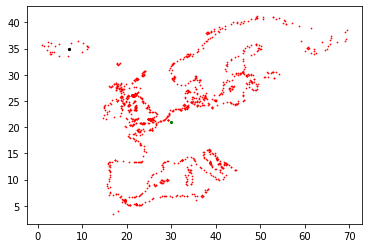

In [131]:
EU_coast = np.loadtxt('../../data/EuropePoints_xp25_ym30.csv', delimiter=',')
vol_y = 35
vol_x = 7
Br_y = 21
Br_x = 30

plt.figure()
plt.scatter(EU_coast[:,0],EU_coast[:,1],s=0.5,c='r')
plt.scatter(vol_x,vol_y,s=5,c='k')
plt.scatter(Br_x,Br_y,s=5,c='g')

(2b .1) Create an instance of a `RasterModelGrid` called `EU`, with 100 rows and 140 columns, with a spacing between nodes of 0.5 degrees (1 degree = ca. 111 km). Calculate the index of the eyjafjallajökull and Brussels within the grid

In [179]:
# (enter your solution to 2b.1 here)
rows = 100
cols = 140
dx = 0.5 # in degrees
# xy spacing in degrees (ca. 111 km)
EU = RasterModelGrid((rows, cols), xy_spacing=dx)

vol_loc = int(vol_y/dx*cols+vol_x/dx)
Br_loc = int(Br_y/dx*cols+Br_x/dx)

(2b.2) Query the grid variables `number_of_nodes` and `number_of_core_nodes` to find out how many nodes are in your grid, and how many of them are core nodes.

In [133]:
# (enter your solution to 2b.2 here)
print(EU.number_of_nodes)
print(EU.number_of_core_nodes)

14000
13524


(2b.3) Add a new field to your grid, called `Aerosol` and attached to nodes. Have the initial values be all zero.

In [134]:
# (enter your solution to 2b.3 here)
a = EU.add_zeros('Aerosol', at='node')

(2b.4) Change the Aerosol concentration at the eyjafjallajökull to an initial concentration of 10 ppm (store this value in `C_ini`) . Use the `imshow_grid` function to display a shaded image of the Aerosol field.

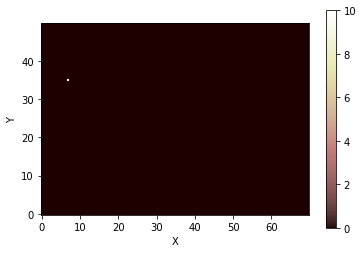

In [135]:
# (enter your solution to 2b.4 here)
C_ini = 10.0
a[vol_loc] = C_ini
imshow_grid(EU, 'Aerosol')

(2b.5) Now lets do some more advanced plotting. Use the `imshow_grid` function to to plot the Aerosol concentration, but this time plot all cells with Aerosol concentrations smaller than 1 ppm as white transparent pixels. To do this, make a copy of the Aerosol field and mask it [see ](https://numpy.org/doc/stable/reference/maskedarray.generic.html). Hint: try using `np.ma.masked_where(..., ...)`. Use the inferno_r colormap (see cmap argument of `imshow_grid`). On top of the concentration field, plot the map of Europe using the statements from the preparation cell above and the EU_coast variable. 

Finally, make a function out of this plotting code snippet so that you can easily reuse it later 

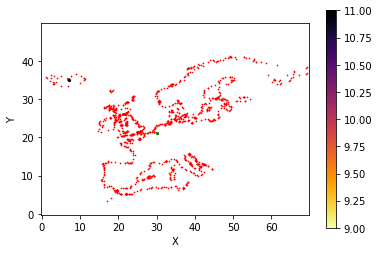

In [136]:
def plot_aerosol(a):
    a_plt = np.zeros_like(a)
    a_plt[:] = a
    a_plt = np.ma.masked_where(a_plt <1, a_plt)
    imshow_grid(EU,a_plt,cmap ='inferno_r',color_for_background=None, color_for_closed=None)        
    plt.scatter(EU_coast[:,0],EU_coast[:,1],s=0.5,c='r')
    plt.scatter(vol_x,vol_y,s=5,c='k')
    plt.scatter(Br_x,Br_y,s=5,c='g')        
    plt.show()
    
plot_aerosol(a)

Define some constants: 
- $C_n$ (source term): amount of dust particles produced per day (20 ppm/day)
- $D$ (diffusion constant) : 1.5  deg$^2$  day$^-1$
- $dt$ (in days, see stability rule before)
- get $dx$ and $dy$ from landlab grid
- totT: the total amount of iterations, see to 1000 for now
- create an empty np array to store the aerosol concentration above Brussels during the model run (with size totT)

In [137]:
C_n = 200
D  = 1.5
dx = EU.dx
dy = EU.dy
dt= 0.245 * EU.dx * EU.dx / D
totT = 1000
Br_out = np.zeros(totT)
time = np.arange(start=0,stop = totT, step = 1)*dt


- Create a new field of zeros called aerosol_flux and attached to links. Using the 'number_of_links' grid property, verify that your new field array has the correct number of items. 

In [1]:
qa = EU.add_zeros('aerosol_flux', at='link')
print(EU.number_of_links)
print(len(qa))

NameError: name 'EU' is not defined

Boundary conditions: for this example, we'll assume that all sides are  are open. (The order of the function arguments is east, north, west, south). This is the default configuration. LAter on we will check what happens if boundary conditions are open. 

In [191]:
EU.set_closed_boundaries_at_grid_edges(True, True, True, True)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 98 + 140 + 98 + 140 = 476 boundary nodes. All the remaining nodes are known as **core** nodes. In this example, there are 100*140-476 = 13524 core nodes:

In [187]:
len(EU.boundary_nodes)
# len(EU.core_nodes)
100*140-476


13524

(2b.7) Now solve the 2D diffusion equation. Loop through totT iterations, representing $totT*dt$ days. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the **aerosol gradient** between each neighboring pair of nodes. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing 𝑥 ("horizontal" links) or increasing 𝑦 ("vertical" links).

2. Calculate, and store in the array `qa`, the **aerosol flux** between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the active links (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate the resulting net flux at each node, (positive=net outflux, negative=net influx). The negative of this array is the rate of change of elevation at each (core) node, so store it in a node array called `dadt'.

4. Update the aerosol concentrations for the new time step.

5. Take care of the source term: calculate the amount of ash being produced during one timestep and add this to the aerosol field at the volcano location

5. Store the concentration above Brussels in the `Br_out` array

6. Plot the resulting concentration every 100 iterations using the 

Time is : 0.0days


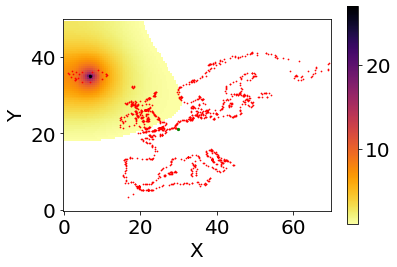

Time is : 4.08333333333days


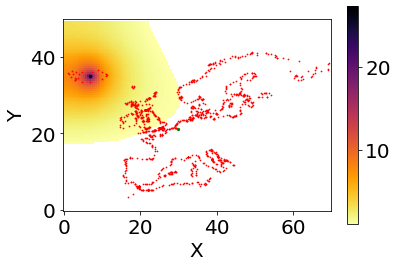

Time is : 8.16666666667days


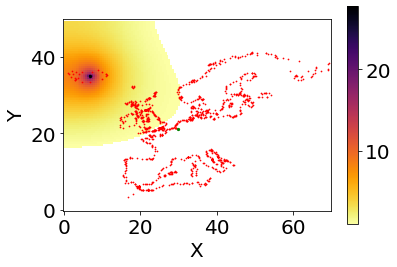

Time is : 12.25days


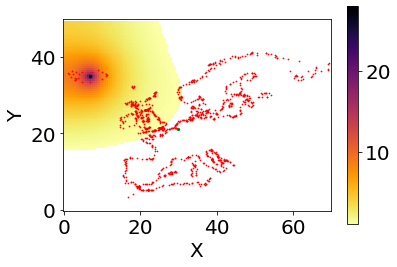

Time is : 16.3333333333days


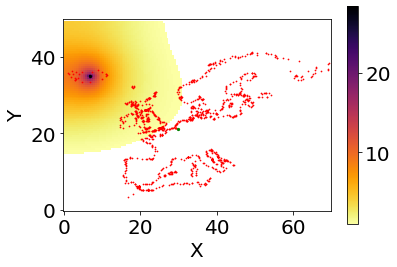

Time is : 20.4166666667days


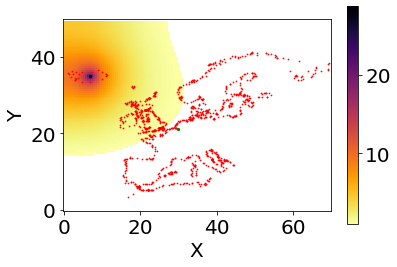

Time is : 24.5days


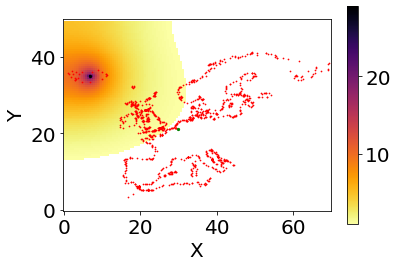

Time is : 28.5833333333days


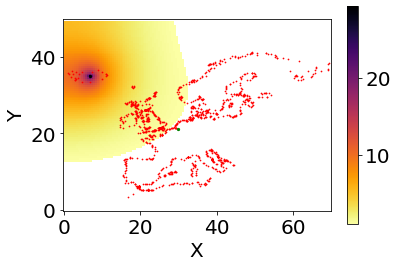

Time is : 32.6666666667days


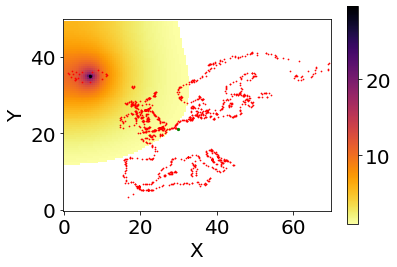

Time is : 36.75days


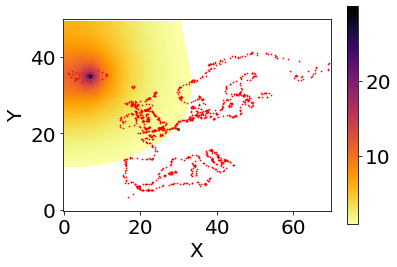

In [190]:
for i in range(totT):  
    g = EU.calc_grad_at_link(a)
    qa[EU.active_links] = -D * g[EU.active_links]
    dadt = -EU.calc_flux_div_at_node(qa)
    a[EU.core_nodes] += dadt[EU.core_nodes] * dt   
    a[vol_loc] += C_n*dt
    Br_out[i] = a[Br_loc]       
    if i%100==0:     
        print('Time is : ' + str(i*dt) + 'days')
        plot_aerosol(a)      


Plot the concentration through time at Brussels

In [2]:
plt.figure()
plt.plot(time,Br_out)

NameError: name 'plt' is not defined

* What happens if you set all of the boundaries as closed boundaries? 
* what happens if you change the vertical (u) velocity to  +0.25? 

## Advection diffusion: 
We have solved the diffusion part of the volcanic ash problem imposed by the eyjafjallajökull volcano. However, most of the ash transport was induced by wind fields advection the ash towards Europe (yup, west winds). Can you come up with a landlab implementation of the advection equation? Copy paste your solution from exercise () and add some lines to solve the 2D advection equation:

$$\frac{\partial C}{\partial t} +v \frac{\partial C}{\partial x} +u \frac{\partial C}{\partial y}=0
\label{eq:1}\tag{1}$$
where $C$ is the aerosol concentration and $v$ is a constant windspeed at which aerosol concentrations are advectected in the x direction and $u$ is a constant windspeed at which aerosol concentrations are advectected in the y direction.

You will need some additional variables: 
- $v$ (horizontal wind speed, positive in x direction): 1.5 deg/day
- $u$ (vertical wind speed, positive in y direction): -0.75 deg/day

- Hint 1: reset the Aerosol field (a)
- Hint 2: update the time criterion and combine the diffusion and the advection criteria 
- Hint 3: currently, the landlab grid library has no predefined functions to calculate advection (no equivalent for calc_flux_div_at_node which is used to solve the heat eq.). Hence, you will have to discretise the advection equation yourself using an upwind first order FDM, but using the matlab node/link structure. To calculate the links at every node, use `links_at_node`
- Hint 4: given that there is no predefined method to calculate advection, you will also have to take care of the boundary conditions. Assume open boundary nodes by setting the aerosol concentration at all boundary nodes to 0 ppm at the end of every iteration. Use `grid.boundary_nodes`.

In [3]:
v = 1.5
u = -.5
C_n = 200
D  = 1.5
dx = EU.dx
dy = EU.dy
totT = 1000
Br_out = np.zeros(totT)
time = np.arange(start=0,stop = totT, step = 1)*dt

a[:] = np.zeros_like(a)
g = np.zeros(EU.number_of_links)
dadt = np.zeros(EU.number_of_nodes)


dt_a = 0.95*np.minimum(dx/abs(v),dy/abs(u))
dt_d = 0.245 * dx * dx / D
dt = min(dt_a,dt_d)

rt = EU.links_at_node[0:len(a)][:,0]
up = EU.links_at_node[0:len(a)][:,1]
lt = EU.links_at_node[0:len(a)][:,2]
dw = EU.links_at_node[0:len(a)][:,3] 

for i in range(totT):  
    EU.calc_grad_at_link(a,out=g)
    qa[EU.active_links] = -D * g[EU.active_links]
    EU.calc_flux_div_at_node(qa,out=dadt)
    a[EU.core_nodes] -= dadt[EU.core_nodes] * dt   
    
    # Advection 
    # horizontal (x) direction
    EU.calc_grad_at_link(a,out=g)    
    if v<0:
        a -= v*g[rt]*dt
    else:             
        a -= v*g[lt]*dt
    
    # vertical (y) direction
    EU.calc_grad_at_link(a,out=g)
    if u<0:
        a -= u*g[up]*dt
    else:
        a -= u*g[dw]*dt
    
    # Or shorter: 
#     EU.calc_grad_at_link(a,out=g)   
#     a -= (v*g[rt]*(v<0) + v*g[lt]*(v>0))*dt
#     EU.calc_grad_at_link(a,out=g)
#     a -= (u*g[up]*(u<0) + u*g[dw]*(u>0))*dt
    
    # Source term   
    a[vol_loc] += C_n*dt
    
    # Keep track of concentration in Brussels
    Br_out[i] = a[Br_loc]
    
    #BC    
    a[mg.boundary_nodes] = 0 
    if i%100==0:     
        print('Time is : ' + str(i*dt) + 'days')
        plot_aerosol(a) 
        
plt.figure()
plt.plot(time,Br_out) 


NameError: name 'EU' is not defined

Congratulations on making it to the end of this tutorial!

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>